In [117]:
import numpy as np
import george
from george import kernels
from scipy.optimize import minimize
from time import time
import argparse
import pickle
import matplotlib.pyplot as plt

In [ ]:
def orig_to_trans(pars):
    gamma=pars[6]
    logM_env=pars[8]
    beta=pars[7]
    incl=pars[14]
    
    pars[6]=np.log10(2.1-1*gamma)
    pars[8]=np.log10(-1.5-1*logM_env)
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=1-np.cos(((beta*c) + (incl*s/60)-.5)*np.pi/2)
    pars[14]=(-beta*s) + (incl*c/60)
    return pars

In [180]:
with open ('./gmd/cubefull.txt', 'rb') as fp:
    old_grid = np.array(pickle.load(fp))
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
xvals=np.load("./etgrid/xvals.npy")
orig_dict=np.load("./gmd/dictionary.npy",allow_pickle=True)

def point(i):
    coords=[]
    for j in param_names:
        coords.append(orig_dict[i][j])
    sed = old_grid[i][100:500]
    return (coords, sed)

In [181]:
#parser=argparse.ArgumentParser()
#parser.add_argument("--name", help="name of pca instance",type=str)
#name = parser.parse_args().name

name = "cobyla"
inst = "3917"
print(np.load("./etgrid/"+inst+"_"+name+"_time_rec.npy")/86400,"days")

fit=np.load("./etgrid/"+inst+"_"+name+"_optimize_result.npy")

1.68242471376227 days


In [182]:
coords=np.load("./etgrid/"+inst+"_coords.npy")
eigenseds=np.load("./etgrid/"+inst+"_eigenseds.npy")
weights=np.load("./etgrid/"+inst+"_weights.npy")
pcamean=np.load("./etgrid/"+inst+"_mean.npy")

yerrs=[]
for i in range(16):
    yerrs.append([x*0.01 for x in weights[i]])


In [183]:
kernel = 16*kernels.ExpSquaredKernel(15**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=14) 
blankhodlr=george.GP(kernel)

In [184]:
sample=np.random.randint(0,3850,10)
sample_coords=[]
for i in range(len(sample)):
    sample_coords.append(point(sample[i])[0])

In [185]:
def pred(pred_coords):
    gp=blankhodlr
    preds=[]
    if "cobyla" in name:
        hyperparams=np.transpose(np.array(fit).reshape(16,16))
    else:
        hyperparams=np.array(fit).reshape(16,16)

    for i in range(len(weights)):  # same covfunc for each weight and the sample mean
        gp.set_parameter_vector(hyperparams[i])
        gp.compute(coords,yerrs[i])
        pred, pred_var = gp.predict(weights[i], pred_coords, return_var=True)
        preds.append(pred)
    reconst_SEDs=[]
    for i in range(len(pred_coords)):
        reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pcamean + np.array(preds)[:,i][15]
        reconst_SEDs.append(reconst)
    return reconst_SEDs, preds


In [136]:
predicted_SEDs, predicted_weights =pred(sample_coords)

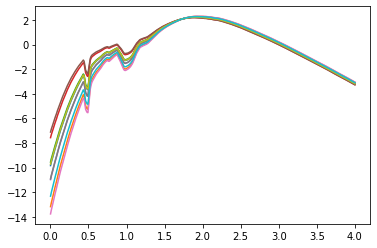

In [138]:
for i in range(len(predicted_SEDs)):
    plt.plot(np.log10(xvals),predicted_SEDs[i])

1063
{'Tstar': 4032.7977712550737, 'logL_star': 2.5049078777895426, 'logM_disk': -5.936413231591065, 'logR_disk': 2.547067286609681, 'h_0': 0.10421988268244177, 'logR_in': -0.5837558200533798, 'gamma': 0.9145205843871885, 'beta': 1.071048728067765, 'logM_env': -4.671873542852068, 'logR_env': 3.5083339162151534, 'f_cav': 0.21817019079184027, 'ksi': 0.9077638865499993, 'loga_max': 0.06374548253051385, 'p': 2.729506281083389, 'incl': 39.285685346101275, 'filename': 'Tstar_4032.798_logLstar_2.505_logMdisk_-5.936_logRdisk_2.547_h0_0.104_logRin_-0.584_gamma_0.915_beta_1.071_logMenv_-4.672_logRenv_3.508_fcav_0.218_ksi_0.908_logamax_0.064_p_2.730_incl_39.286.hdf5'}


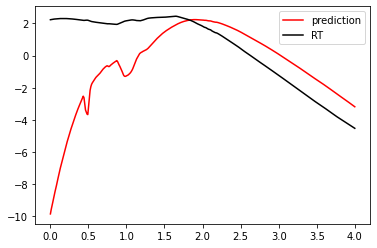

3119
{'Tstar': 4545.147059739983, 'logL_star': -0.9586804771607147, 'logM_disk': -4.401884499315987, 'logR_disk': 2.8679407535897776, 'h_0': 0.011202781456235676, 'logR_in': 1.0110642728898394, 'gamma': 0.7845079681684806, 'beta': 0.877177280686471, 'logM_env': -5.066462476091173, 'logR_env': 3.792394411785039, 'f_cav': 0.6426002584267443, 'ksi': 0.624450311187621, 'loga_max': 1.5013582281315356, 'p': 3.5746526468645996, 'incl': 64.33967327672319, 'filename': 'Tstar_4545.147_logLstar_-0.959_logMdisk_-4.402_logRdisk_2.868_h0_0.011_logRin_1.011_gamma_0.785_beta_0.877_logMenv_-5.0_logRenv_3.792_fcav_0.643_ksi_0.624_logamax_1.501_p_3.575_incl_64.340.hdf5'}


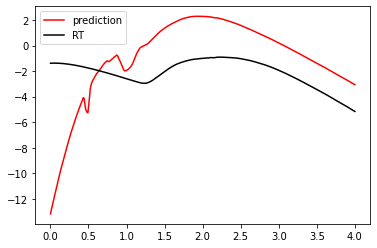

3197
{'Tstar': 4568.365906820627, 'logL_star': 0.7102264761829948, 'logM_disk': -5.667857431822789, 'logR_disk': 2.3654526846659913, 'h_0': 0.064553920204909, 'logR_in': 2.2736084747006755, 'gamma': 0.9017420898722831, 'beta': 1.6896715245918008, 'logM_env': -4.539608004066338, 'logR_env': 2.8558145526598313, 'f_cav': 0.493097922522883, 'ksi': 0.9127820199914976, 'loga_max': 3.206855500771236, 'p': 3.765572222541322, 'incl': 31.77208365183199, 'filename': 'Tstar_4568.3_logLstar_0.710_logMdisk_-5.8_logRdisk_2.365_h0_0.065_logRin_2.274_gamma_0.902_beta_1.690_logMenv_-4.540_logRenv_2.856_fcav_0.493_ksi_0.913_logamax_3.207_p_3.7_incl_31.772.hdf5'}


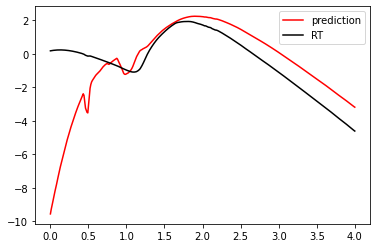

2384
{'Tstar': 4975.0520798637635, 'logL_star': 1.8429491773427795, 'logM_disk': -5.7200369784661245, 'logR_disk': 1.8204168371003089, 'h_0': 0.1625434274792321, 'logR_in': 0.12329657140367911, 'gamma': 0.9762863352500939, 'beta': 1.7599967683634403, 'logM_env': -5.374671426793651, 'logR_env': 3.2679783604738866, 'f_cav': 0.644562310738918, 'ksi': 1.3508104995202745, 'loga_max': 0.20072993428909017, 'p': 4.347128810969865, 'incl': 13.635555257608969, 'filename': 'Tstar_4975.052_logLstar_1.843_logMdisk_-5.720_logRdisk_1.820_h0_0.163_logRin_0.123_gamma_0.976_beta_1.760_logMenv_-5.375_logRenv_3.268_fcav_0.645_ksi_1.351_logamax_0.201_p_4.347_incl_13.636.hdf5'}


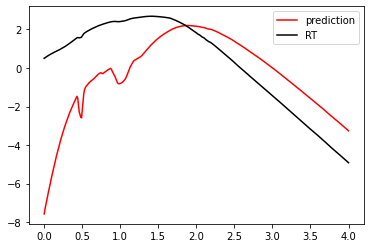

609
{'Tstar': 3651.992639768252, 'logL_star': 2.285863078158502, 'logM_disk': -4.657179731642265, 'logR_disk': 2.568387865707636, 'h_0': 0.032468188201269045, 'logR_in': -0.7834056938147109, 'gamma': 1.1372207893787594, 'beta': 0.5132462032747718, 'logM_env': -4.560581127787433, 'logR_env': 3.478403456913534, 'f_cav': 0.9046970358188096, 'ksi': 1.1219499061979252, 'loga_max': 0.8965829423418686, 'p': 3.080371683249927, 'incl': 45.683407963569024, 'filename': 'Tstar_3651.993_logLstar_2.286_logMdisk_-4.657_logRdisk_2.568_h0_0.032_logRin_-0.783_gamma_1.137_beta_0.513_logMenv_-4.561_logRenv_3.478_fcav_0.905_ksi_1.122_logamax_0.897_p_3.080_incl_45.683.hdf5'}


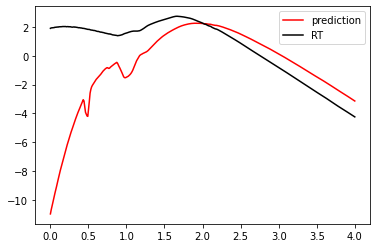

1767
{'Tstar': 3180.275274283843, 'logL_star': 0.4055270624234888, 'logM_disk': -7.575595859100412, 'logR_disk': 2.3118770103238866, 'h_0': 0.4025699210620559, 'logR_in': -0.2456093345494601, 'gamma': 0.8557849499233884, 'beta': 0.982752242571396, 'logM_env': -4.0694329645793985, 'logR_env': 3.885943336103801, 'f_cav': 0.5697446680275856, 'ksi': 1.049024201734266, 'loga_max': 3.202655101059319, 'p': 3.0886693130581637, 'incl': 1.0065522497490074, 'filename': 'Tstar_3180.275_logLstar_0.406_logMdisk_-7.576_logRdisk_2.312_h0_0.403_logRin_-0.246_gamma_0.856_beta_0.983_logMenv_-4.069_logRenv_3.6_fcav_0.570_ksi_1.049_logamax_3.203_p_3.089_incl_1.007.hdf5'}


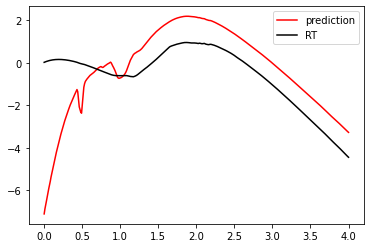

603
{'Tstar': 3301.3016623233257, 'logL_star': 0.49842003066139706, 'logM_disk': -6.87981598631257, 'logR_disk': 0.8467014078062347, 'h_0': 0.1410119267564523, 'logR_in': -0.570266797801109, 'gamma': 1.7803557696935723, 'beta': 1.6670570572185044, 'logM_env': -4.843034605622677, 'logR_env': 3.9684591873555752, 'f_cav': 0.6075889720797156, 'ksi': 1.0695500780078566, 'loga_max': 0.6269018213010623, 'p': 3.205115915437246, 'incl': 66.49624819654191, 'filename': 'Tstar_3301.302_logLstar_0.498_logMdisk_-6.0_logRdisk_0.847_h0_0.141_logRin_-0.570_gamma_1.780_beta_1.7_logMenv_-4.843_logRenv_3.968_fcav_0.608_ksi_1.070_logamax_0.627_p_3.205_incl_.496.hdf5'}


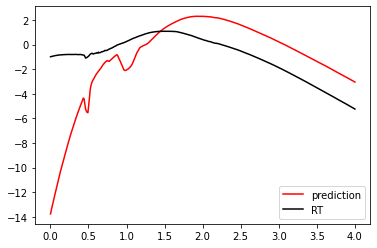

3465
{'Tstar': 3829.5789493229636, 'logL_star': 2.0991115187379843, 'logM_disk': -7.3682912631622965, 'logR_disk': 2.37241330673144, 'h_0': 0.12498699415804634, 'logR_in': 1.5675968132943936, 'gamma': 0.5331289739703031, 'beta': 1.340225987979159, 'logM_env': -6.390796229055649, 'logR_env': 3.219911543498204, 'f_cav': 0.7047489246308304, 'ksi': 1.1367541624885256, 'loga_max': 3.713166655158015, 'p': 3.075490941992288, 'incl': 44.774795498496026, 'filename': 'Tstar_3829.579_logLstar_2.099_logMdisk_-7.368_logRdisk_2.372_h0_0.125_logRin_1.568_gamma_0.533_beta_1.340_logMenv_-6.391_logRenv_3.220_fcav_0.705_ksi_1.137_logamax_3.713_p_3.075_incl_44.775.hdf5'}


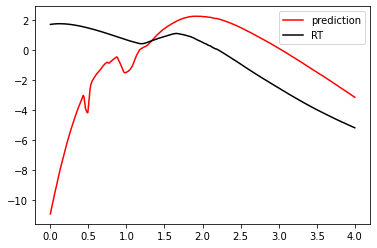

3568
{'Tstar': 3702.805501147962, 'logL_star': 2.571806749731133, 'logM_disk': -3.51055551078505, 'logR_disk': 1.0863122940576233, 'h_0': 0.4074222455774677, 'logR_in': 0.1165421489197429, 'gamma': 0.24705378344033627, 'beta': 1.219975959906098, 'logM_env': -7.630938317515724, 'logR_env': 2.875924181222485, 'f_cav': 0.5546998602156293, 'ksi': 0.5830524312574857, 'loga_max': 3.7698549393220384, 'p': 3.484967225435719, 'incl': 35.884801751881994, 'filename': 'Tstar_3702.806_logLstar_2.572_logMdisk_-3.511_logRdisk_1.086_h0_0.407_logRin_0.117_gamma_0.247_beta_1.220_logMenv_-7.631_logRenv_2.876_fcav_0.555_ksi_0.583_logamax_3.770_p_3.485_incl_35.5.hdf5'}


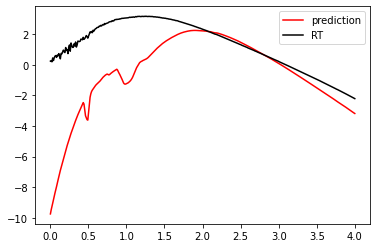

2548
{'Tstar': 4023.8898725458776, 'logL_star': 2.2743154591889096, 'logM_disk': -6.856271547514606, 'logR_disk': 1.338571591191009, 'h_0': 0.0954835911134987, 'logR_in': 0.7702494671509572, 'gamma': 1.458901501481212, 'beta': 0.9117950983967987, 'logM_env': -7.897813420876315, 'logR_env': 3.095593561742364, 'f_cav': 0.5512627282688279, 'ksi': 0.6976669323753721, 'loga_max': 0.012605698798836726, 'p': 2.75751807215629, 'incl': 58.83136856957044, 'filename': 'Tstar_4023.890_logLstar_2.274_logMdisk_-6.856_logRdisk_1.339_h0_0.095_logRin_0.770_gamma_1.459_beta_0.912_logMenv_-7.898_logRenv_3.096_fcav_0.551_ksi_0.698_logamax_0.013_p_2.758_incl_58.831.hdf5'}


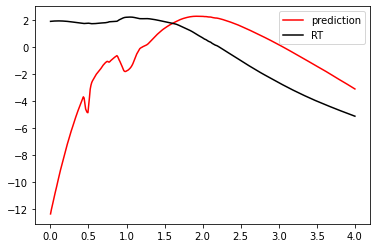

In [139]:
for i in range(len(predicted_SEDs)):
    print(sample[i])
    print(orig_dict[sample[i]])
    plt.plot(np.log10(xvals),predicted_SEDs[i],c='r',label="prediction")
    plt.plot(np.log10(xvals),point(sample[i])[1],c='k',label="RT")
    plt.legend()
    plt.show()

In [199]:
from sklearn.decomposition import PCA


# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.550s


In [200]:
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)[:,:,100:500]
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)[:,:,100:500]

# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

In [201]:
fitdata=[]

for i in range(len(param_names)):
    fitdata.append([])
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)

In [202]:
paramvals=[]
weights=[]
for param in range(15):
    pl=[]
    wl=[]
    for model in range(11):
        pl.append(fitdata[param][model][0])
    paramvals.append(pl)
    
    for w in range(10):
        wsl=[]
        for model in range(11):
            wsl.append(fitdata[param][model][w+1])
        wl.append(wsl)
    weights.append(wl)

In [203]:
def load_pcwpar(param,weight):
    return np.array(paramvals[param]).reshape(-1,1), np.array(weights[param][weight])

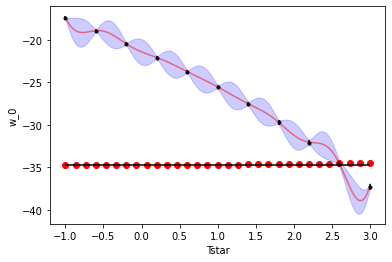

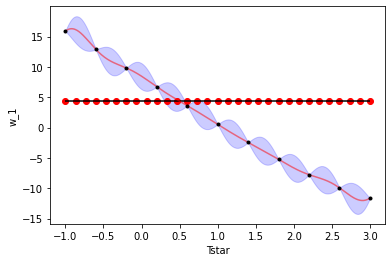

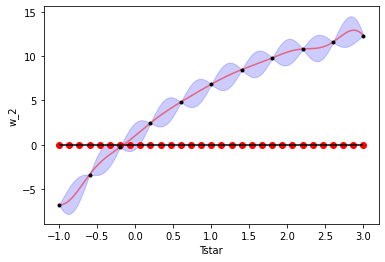

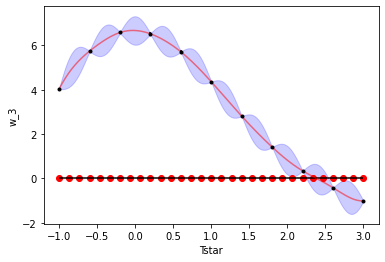

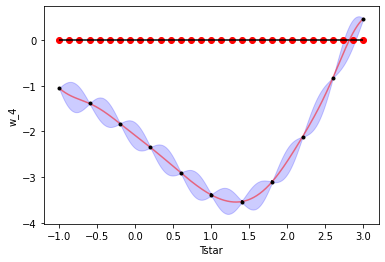

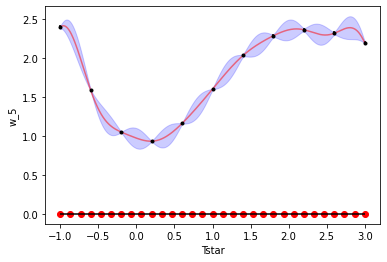

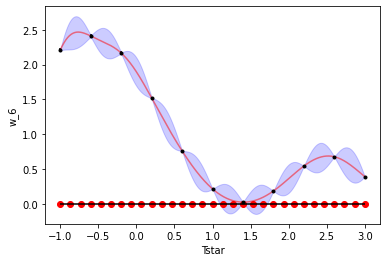

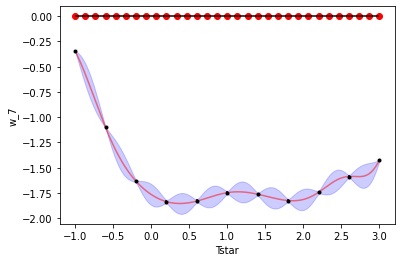

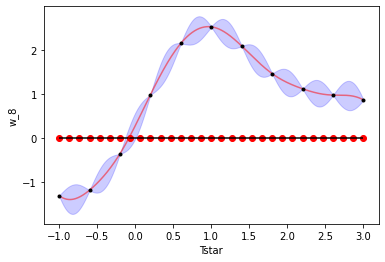

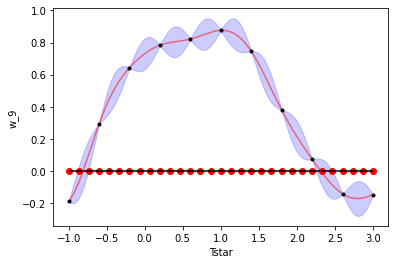

IndexError: list index out of range

In [212]:
for i in range(15):
    aX, ay = load_pcwpar(1,i)
    ayerr=[j*0.01 for j in ay]

    akernel = kernels.ExpSquaredKernel(.3**2) * np.var(ay)

    agp = george.GP(akernel)
    agp.compute(aX,ayerr)

    ax_pred = np.linspace(-1,3,500)
    apred, apred_var = agp.predict(ay, ax_pred, return_var=True)

    plt.fill_between(ax_pred, apred - np.sqrt(apred_var), apred + np.sqrt(apred_var),
                    color="b", alpha=0.2)
    plt.plot(ax_pred, apred, "r", lw=1.5, alpha=0.5)
    plt.xlabel("Tstar")
    plt.ylabel("w_"+str(i))
    plt.scatter(np.array(slicepoints)[:,1],slice_weights[i],c='r')
    plt.hlines(slice_weights[i][0],xmin=ranges[1][0],xmax=ranges[1][1])
    plt.errorbar(aX, ay, ayerr,fmt=".k", capsize=0)
    plt.show()

In [173]:
slicepoints=[]
for i in range(31):
    point=[]
    for j in range(len(bases)):
        if j!=1:
            point.append(bases[j])
        else:
            point.append(ranges[1][0]+(i/30)*(ranges[1][1]-ranges[1][0]))
    slicepoints.append(point)

In [195]:
slice_SEDs, slice_weights =pred(slicepoints)